# Práctica Sistemas Distribuidos II

## 1. Introducción

El objetivo de la práctica es el procesamiento y análisis básico de datos estructurados con PySpark. En particular, usaremos la API de Spark SQL para llevar a cabo estas labores.

### 1.1 Dataset

El conjunto de datos para la práctica es AirBnB listings in major US cities, que se puede descargar directamente de Kaggle Datasets: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml
El objetivo de la competición en la que se publicó este dataset era predecir el precio de los anuncios publicados en AirBnB, en ciudades de gran tamaño de EE.UU. Existen dos archivos en el dataset:
- train.csv:Datos de entrenamiento para un algoritmo de predicción de precios.
- test.csv:Datos de testing para evaluar objetivamente el rendimiento del algoritmo.

Se pueden observar los campos que poseen cada fila en la dirección url del dataset.


## 2 Preparación inicial
> Carga los datos del archivo train.csv en Spark, utilizando la función spark.read.csv(...) que se ha visto durante el curso. Debes escoger los argumentos apropiados para leer los datos sin errores y escogiendo el tipo de dato más apropiado para cada variable.

### 2.1 Imports

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from pyspark.sql.types import *
from pyspark.sql import SQLContext
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
from datetime import datetime
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pandas_profiling import ProfileReport
from pyspark.sql import functions as F
from pyspark.sql.window import Window

### 2.2 Configuración SparkSession

En primer lugar, se especifica la ruta de la versión de java necesaria.

In [2]:
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jdk1.8.0_281"
os.environ["JAVA_HOME"]

'C:/Program Files/Java/jdk1.8.0_281'

En segundo lugar, se levanta la sesión de spark y se comprueba que los settings han sido correctamente configurados.

In [3]:
spark = (SparkSession.builder
    .master("local[*]")
    .config("spark.driver.cores", 1)
    .appName("Analysis AirBnB")
    .getOrCreate() )
sc = spark.sparkContext
spark

### 2.3. Lectura de los datos

Tras una primera visualización de los datos se configura el structure type correspondiente para la lectura, por parte de spark del fichero train.csv

In [156]:
creditsSchema = StructType([StructField("id", DoubleType(), True), 
                           StructField("log_price", DoubleType(), True),
                           StructField("property_type", StringType(), True),
                           StructField("room_type", StringType(), True),
                           StructField("amenities", StringType(), True),
                           StructField("accommodates", IntegerType(), True),
                           StructField("bathrooms", FloatType(), True),
                           StructField("bed_type", StringType(), True),
                           StructField("cancellation_policy", StringType(), True),
                           StructField("cleaning_fee", BooleanType(), True),
                           StructField("city", StringType(), True),
                           StructField("description", StringType(), True),
                           StructField("first_review", DateType(), True),
                           StructField("host_has_profile_pic", StringType(), True),
                           StructField("host_identity_verified", StringType(), True),
                           StructField("host_response_rate", StringType(), True),
                           StructField("host_since", DateType(), True),
                           StructField("instant_bookable", StringType(), True),
                           StructField("last_review", DateType(), True),         
                           StructField("latitude", DoubleType(), True),         
                           StructField("longitude", DoubleType(), True),       
                           StructField("name", StringType(), True),
                           StructField("neighbourhood", StringType(), True),         
                           StructField("number_of_reviews", IntegerType(), True),      
                           StructField("review_scores_rating", DoubleType(), True),         
                           StructField("thumbnail_url", StringType(), True),                             
                           StructField("zipcode", IntegerType(), True),         
                           StructField("bedrooms", FloatType(), True),         
                           StructField("beds", FloatType(), True)
                           ])

In [157]:
df_spark = (spark.read.option("header", "true")
#           .option("dateFormat", "yyyy-MM-dd") // Default
           .option("quote", "\"")  
           .option("escape", "\"") 
           .csv("../data/train.csv", schema=creditsSchema)
          )

Se va a realizar una observación de las cinco primeras columnas para los datos importados para comprobar que han sido correctamente leidos por parte de spark.

In [163]:
df_spark.select('id','log_price','property_type','room_type','amenities','accommodates','bathrooms','bed_type').show(5)

+-----------+------------------+-------------+---------------+--------------------+------------+---------+--------+
|         id|         log_price|property_type|      room_type|           amenities|accommodates|bathrooms|bed_type|
+-----------+------------------+-------------+---------------+--------------------+------------+---------+--------+
|  6901257.0| 5.010635294096256|    Apartment|Entire home/apt|{"Wireless Intern...|           3|      1.0|Real Bed|
|  6304928.0|5.1298987149230735|    Apartment|Entire home/apt|{"Wireless Intern...|           7|      1.0|Real Bed|
|  7919400.0| 4.976733742420574|    Apartment|Entire home/apt|{TV,"Cable TV","W...|           5|      1.0|Real Bed|
|1.3418779E7| 6.620073206530356|        House|Entire home/apt|{TV,"Cable TV",In...|           4|      1.0|Real Bed|
|  3808709.0|  4.74493212836325|    Apartment|Entire home/apt|{TV,Internet,"Wir...|           2|      1.0|Real Bed|
+-----------+------------------+-------------+---------------+----------

In [164]:
df_spark.select('cancellation_policy','cleaning_fee','city','description','first_review','host_has_profile_pic','host_identity_verified').show(5)

+-------------------+------------+----+--------------------+------------+--------------------+----------------------+
|cancellation_policy|cleaning_fee|city|         description|first_review|host_has_profile_pic|host_identity_verified|
+-------------------+------------+----+--------------------+------------+--------------------+----------------------+
|             strict|        true| NYC|Beautiful, sunlit...|  2016-06-18|                   t|                     t|
|             strict|        true| NYC|Enjoy travelling ...|  2017-08-05|                   t|                     f|
|           moderate|        true| NYC|The Oasis comes c...|  2017-04-30|                   t|                     t|
|           flexible|        true|  SF|This light-filled...|        null|                   t|                     t|
|           moderate|        true|  DC|Cool, cozy, and c...|  2015-05-12|                   t|                     t|
+-------------------+------------+----+-----------------

In [165]:
df_spark.select('host_response_rate','host_since','instant_bookable','last_review','latitude','longitude','name').show(5)

+------------------+----------+----------------+-----------+------------------+-------------------+--------------------+
|host_response_rate|host_since|instant_bookable|last_review|          latitude|          longitude|                name|
+------------------+----------+----------------+-----------+------------------+-------------------+--------------------+
|              null|2012-03-26|               f| 2016-07-18|40.696523629970756| -73.99161684624262|Beautiful brownst...|
|              100%|2017-06-19|               t| 2017-09-23|40.766115415949685| -73.98903992265213|Superb 3BR Apt Lo...|
|              100%|2016-10-25|               t| 2017-09-14| 40.80810998936211| -73.94375584395794|    The Garden Oasis|
|              null|2015-04-19|               f|       null|37.772004482560774|-122.43161868239788|Beautiful Flat in...|
|              100%|2015-03-01|               t| 2017-01-22|38.925626916626506|  -77.0345955156553|Great studio in m...|
+------------------+----------+-

In [166]:
df_spark.select('neighbourhood','number_of_reviews','review_scores_rating','thumbnail_url','zipcode','bedrooms').show(5)

+----------------+-----------------+--------------------+--------------------+-------+--------+
|   neighbourhood|number_of_reviews|review_scores_rating|       thumbnail_url|zipcode|bedrooms|
+----------------+-----------------+--------------------+--------------------+-------+--------+
|Brooklyn Heights|                2|               100.0|https://a0.muscac...|  11201|     1.0|
|  Hell's Kitchen|                6|                93.0|https://a0.muscac...|  10019|     3.0|
|          Harlem|               10|                92.0|https://a0.muscac...|  10027|     1.0|
|            null|             null|                null|                null|   null|    null|
|Columbia Heights|                4|                40.0|                null|  20009|     0.0|
+----------------+-----------------+--------------------+--------------------+-------+--------+
only showing top 5 rows



A continuación se ha realizado un tratamiento de la variable *amenities*. Para ello se han obtenido los valores únicos que contenia dicha variable y se han incluido como columnas, marcando con *true* o *false* si la observación contenia la variable o no.

In [167]:
df=pd.read_csv("../data/train.csv")

In [168]:
df['amenities'] = df['amenities'].map(lambda x: "&".join([x.replace("}", "").replace("{", "").replace('"', "") for x in x.split(",")]))
posible_values = np.unique(np.concatenate(df['amenities'].map(lambda x: x.split("&")).values))
posible_values=np.delete(posible_values,0)
amenity_arr = np.array([df['amenities'].map(lambda x: val in x) for val in posible_values])
for i,am in tqdm(enumerate(posible_values)):
    df[am]=amenity_arr[i]

131it [00:00, 3324.06it/s]


In [169]:
def equivalent_type(f):
    if f == 'datetime64[ns]': return TimestampType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return FloatType()
    elif f=='object': return StringType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
      struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return sqlCtx.createDataFrame(pandas_df, p_schema)

In [90]:
sqlCtx = SQLContext(sc)
spark_df = pandas_to_spark(df)

Se muestra un esquema para la comprobación del correcto funcionamiento de las funciones anteriores.

In [170]:
spark_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- log_price: float (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- amenities: string (nullable = true)
 |-- accommodates: long (nullable = true)
 |-- bathrooms: float (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: string (nullable = true)
 |-- city: string (nullable = true)
 |-- description: string (nullable = true)
 |-- first_review: string (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- name: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- nu

## 3. Análisis Exploratorio de Datos (EDA)

> Toma una muestra aleatoria de 1.000 filas del DataFrame. Utilizando seaborn , Altair, Plotly o directamente con matplotlib, visualiza varios gráficos en los que se muestre las distribuciones de valores de las variables cuantitativas y cualitativas del dataset. Presta especial atención a los valores faltantes que puedan encontrarse en algunas columnas de este archivo de datos.

Se ha seleccionado aleatoriamente una muestra de 1000 observaciones y se ha empleado la funcion ProfileReport para la obtención de graficos y estadisticos importantes para cada variable.

In [79]:
sample=df.sample(n=1000,random_state=1)
profile = ProfileReport(sample, title='AirBnB Pandas Profiling Report')
profile

**Ejercicio 1**
>Identifica las 10 entradas con mayor precio en el dataset train.csv junto con la ciudad en la que está ubicada cada una de ellas.

>¿Cuántas entradas de este dataset crees que se pueden considerar extremadamente caras (datos atípicos con valores muy altos)? Para razonar tu respuesta, puedes representar un histograma o un diagrama de densidad de probabilidad de los precios del dataset.

Para la realización de la query se ha ordenado de forma descendente por precio de logaritmo y se ha decidido mostrar el logaritmo del precio y la ciudad. Se han seleccionado las diez primeras observaciones.

In [33]:
 spark_df.sort("log_price", ascending=False).select('log_price','city').show(10)

+---------+----+
|log_price|city|
+---------+----+
|7.6004024| NYC|
|7.6004024|  LA|
|7.6004024|  DC|
|7.6004024| NYC|
|7.6004024|  DC|
| 7.598399|  SF|
| 7.598399|  LA|
| 7.598399|  LA|
| 7.598399|  DC|
| 7.598399|  LA|
+---------+----+
only showing top 10 rows



De los resultados obtenidos se aprecia que las casas más caras se encuentran en *NYC*, *LA*, *DC* y *SF*.

Para observar que viviendas podrían considerarse como valores atípicos se ha realizado una visualización mediante un histograma.

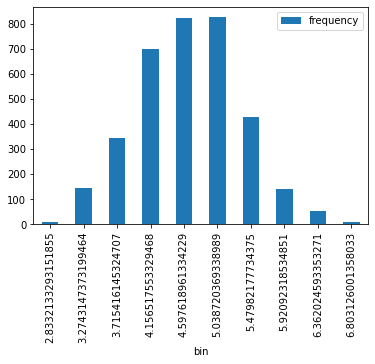

In [171]:
gre_histogram = spark_df.select("log_price").rdd.flatMap(lambda x: x).histogram(10)
pd.DataFrame(
list(zip(*gre_histogram)),
columns=["bin", "frequency"]
).set_index("bin"
).plot(kind="bar");

Se podría considerar que las casas que tienen un logaritmo del precio mayor que 6.8, que son los coincidentes con el ultimo fragmento.

**Ejercicio 2**

In [42]:
spark_df[spark_df['Wireless Internet']==True].count()

71265

In [45]:
spark_df[spark_df['Wireless Internet']==True].groupBy('city').count().show()

+-------+-----+
|   city|count|
+-------+-----+
|     LA|21351|
|     DC| 5472|
|Chicago| 3576|
|     SF| 6214|
| Boston| 3348|
|    NYC|31304|
+-------+-----+



**Ejercicio 3**

In [46]:
spark_df[~spark_df['city'].isin('LA','NYC')].groupBy('city').count().show()

+-------+-----+
|   city|count|
+-------+-----+
|     DC| 5688|
|Chicago| 3719|
|     SF| 6434|
| Boston| 3468|
+-------+-----+



In [98]:
creditsSchema_test = StructType([StructField("id", DoubleType(), True),
                           StructField("property_type", StringType(), True),
                           StructField("room_type", StringType(), True),
                           StructField("amenities", StringType(), True),
                           StructField("accommodates", IntegerType(), True),
                           StructField("bathrooms", FloatType(), True),
                           StructField("bed_type", StringType(), True),
                           StructField("cancellation_policy", StringType(), True),
                           StructField("cleaning_fee", BooleanType(), True),
                           StructField("city", StringType(), True),
                           StructField("description", StringType(), True),
                           StructField("first_review", DateType(), True),
                           StructField("host_has_profile_pic", StringType(), True),
                           StructField("host_identity_verified", StringType(), True),
                           StructField("host_response_rate", StringType(), True),
                           StructField("host_since", DateType(), True),
                           StructField("instant_bookable", BooleanType(), True),
                           StructField("last_review", DateType(), True),         
                           StructField("latitude", DoubleType(), True),         
                           StructField("longitude", DoubleType(), True),       
                           StructField("name", StringType(), True),
                           StructField("neighbourhood", StringType(), True),         
                           StructField("number_of_reviews", IntegerType(), True),      
                           StructField("review_scores_rating", DoubleType(), True),         
                           StructField("thumbnail_url", StringType(), True),                             
                           StructField("zipcode", IntegerType(), True),         
                           StructField("bedrooms", FloatType(), True),         
                           StructField("beds", FloatType(), True)
                           ])

In [99]:
df_spark_test = (spark.read.option("header", "true")
#           .option("dateFormat", "yyyy-MM-dd") // Default
           .option("quote", "\"")  # Tuning escape double quotes
           .option("escape", "\"") # Tuning escape double quotes
           .csv("../data/test.csv", schema=creditsSchema_test)
          )

In [100]:
df_spark_test[~df_spark_test['city'].isin('LA','NYC')].groupBy('city').count().show()

+-------+-----+
|   city|count|
+-------+-----+
|     DC| 1874|
|Chicago| 1365|
|     SF| 2237|
| Boston| 1175|
+-------+-----+



**Ejercicio 4**

In [125]:
spark_df[spark_df['city']=='Boston'].sort("last_review").select('city','last_review').show(10)

+------+-----------+
|  city|last_review|
+------+-----------+
|Boston| 2010-11-04|
|Boston| 2013-06-02|
|Boston| 2014-06-22|
|Boston| 2014-07-02|
|Boston| 2014-08-02|
|Boston| 2014-08-09|
|Boston| 2014-08-09|
|Boston| 2014-08-11|
|Boston| 2014-08-30|
|Boston| 2014-08-31|
+------+-----------+
only showing top 10 rows



In [126]:
my_window = Window.partitionBy().orderBy("last_review")
spark_df = spark_df[spark_df['city']=='Boston'].withColumn("prev_date", F.lag(spark_df.last_review).over(my_window)) 
spark_df=spark_df.withColumn("resta", datediff(col("last_review"),col("prev_date")))

In [127]:
spark_df.select('city','last_review','prev_date','resta').show(5)

+------+-----------+----------+-----+
|  city|last_review| prev_date|resta|
+------+-----------+----------+-----+
|Boston| 2010-11-04|      null| null|
|Boston| 2013-06-02|2010-11-04|  941|
|Boston| 2014-06-22|2013-06-02|  385|
|Boston| 2014-07-02|2014-06-22|   10|
|Boston| 2014-08-02|2014-07-02|   31|
+------+-----------+----------+-----+
only showing top 5 rows



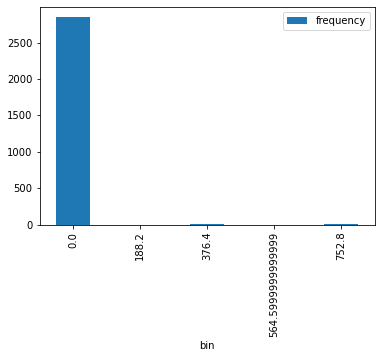

In [149]:
gre_histogram = spark_df.select("resta").rdd.flatMap(lambda x: x).histogram(5)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
list(zip(*gre_histogram)),
columns=["bin", "frequency"]
).set_index("bin"
).plot(kind="bar");

**Ejercicio 5**

In [130]:
spark_df[spark_df['review_scores_rating']<=30.0].select('number_of_reviews').describe().show()

+-------+-----------------+
|summary|number_of_reviews|
+-------+-----------------+
|  count|                6|
|   mean|              1.0|
| stddev|              0.0|
|    min|                1|
|    max|                1|
+-------+-----------------+



In [136]:
spark_df[spark_df['review_scores_rating']<=30.0].select('review_scores_rating','number_of_reviews','cleaning_fee','cancellation_policy').show()

+--------------------+-----------------+------------+-------------------+
|review_scores_rating|number_of_reviews|cleaning_fee|cancellation_policy|
+--------------------+-----------------+------------+-------------------+
|                20.0|                1|       false|           flexible|
|                20.0|                1|        true|             strict|
|                20.0|                1|        true|             strict|
|                20.0|                1|       false|           flexible|
|                20.0|                1|        true|             strict|
|                20.0|                1|        true|             strict|
+--------------------+-----------------+------------+-------------------+

